<a href="https://colab.research.google.com/github/slavyolov/Algorithms/blob/main/Statistics_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
import warnings

# Code block where warnings are ignored
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")  # Ignore all warnings

In [45]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [46]:
!ls

drive  sample_data


# Assignment details
## **Task:**
Use the provided datasets to perform the homogeneity test for one or more segments using the risk variable granted amount.

## **Data:**
Snapshots of all clients/facilities at the beginning and end of the observation date (observation date, identifiers, exposure amounts, default information, segmentation information, model information, …). For a data dictionary help table please see Appendix section.

## **Background:**
The purpose of the test to ensure that the proposed model does not group exposures of significantly different risk characteristics (w.r.t the predicted parameter) in the same rating grade or pool. The test compares for each combination of rating grade/pool and bin of the considered risk variable the observed default rate of exposures within the bin to outside the bin. If a risk driver is not categorical and not already binned, then it is binned into tertiles (low, medium, high). **A significance level of 2.5% is set for this test.**


# **Homogenity test**
A homogeneity test is used to determine whether two or more groups or populations are homogeneous or similar with respect to a particular characteristic or variable. The test helps to assess whether the observed differences between groups are statistically significant or if they can be attributed to random chance.

**The chi-squared homogeneity test answers the question do these two (or more) samples come from the same population?**

# **Setting the hypothesis (regarding the homogeneity of the groups or populations)**
- null hypothesis (H₀) -  assumes that there is no significant difference between the groups
- alternative hypothesis (H₁) - suggests that there is a significant difference.

# **Data analysis**

## Read and display the data

In [49]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("/content/drive/MyDrive/Statistics/PD_Data_prep.csv")
df.drop(columns=["Unnamed: 0"], inplace=True)
df.head()
# print(df.info())
# print(df.describe().T)

,cohort_obs_dt,segment_calibration,consolidated_id,default_first_in_12M_dt,pd_model_class,pd_model_pct,pd_decided_class,pd_decided_pct,issued_or_outstanding_amt_EUR,granted_amt_EUR,EaD_amt_EUR,RWA_amt_EUR,Validation_sample
0,12/31/2021,MC,894649,NaN,3,0.002172,3,0.002172,10719602.04,11253399.26,2248320.40,830873.37,1
1,12/31/2022,MC,156028,NaN,6,0.024611,6,0.024611,10909561.43,11578473.65,2286312.29,1988221.54,1
2,12/31/2021,LC,89270,NaN,5,0.010027,5,0.010027,610341.92,1610341.92,361641.92,194084.49,1
3,12/31/2022,LC,995075,NaN,2,0.001260,2,0.001260,634525.00,1635000.00,238205.00,50170.38,1
4,12/31/2021,LC,629963,NaN,4,0.004863,4,0.004863,156861.64,300000.00,31372.33,30385.33,1


10.17 % of the data points in the class variable columns are not equal


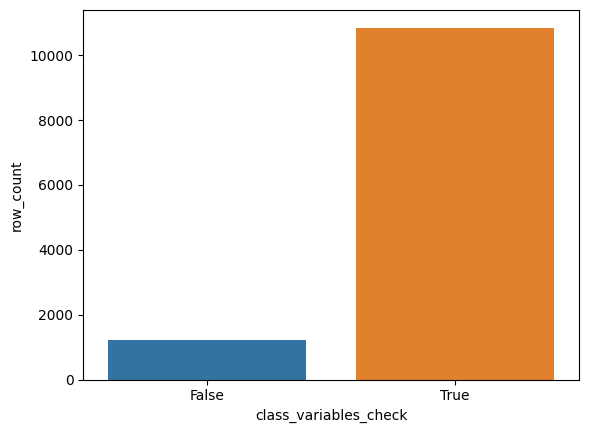

In [50]:
# check pd_model_class and pd_decided_class equality
df["class_variables_check"] = df["pd_model_class"] == df["pd_decided_class"]

# We have two segments -> Therefore we must implement two homogenity test (1 for LC and 1 for MC)
counts_model_class = df.groupby(['class_variables_check'])["Validation_sample"].count()
counts_model_class = counts_model_class.reset_index()
counts_model_class.columns = ["class_variables_check", "row_count"]

sns.barplot(data=counts_model_class, x="class_variables_check", y="row_count")
print(str(round((1228 / (1228+10851) * 100), 2)),
      "% of the data points in the class variable columns are not equal") # 10% of the data is different

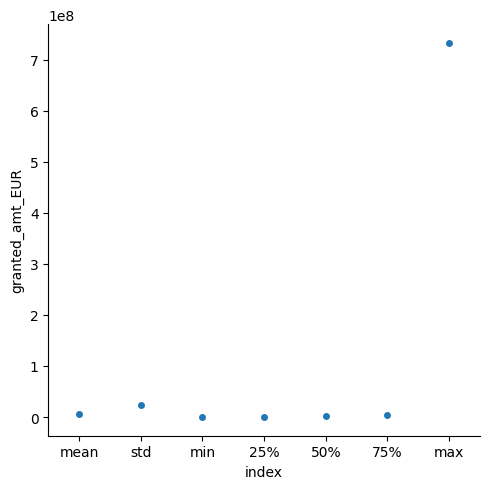

In [51]:
describe_num_df = df[["granted_amt_EUR"]].describe(include=['int64', 'float64'])
describe_num_df.reset_index(inplace=True)
describe_num_df = describe_num_df[describe_num_df['index'] != 'count']
for i in describe_num_df.columns:
    if i in ['index']:
        continue
    sns.catplot(x='index', y=i, data=describe_num_df)
    plt.show()


In [52]:
# We have two segments -> Therefore we must implement two homogenity test (1 for LC and 1 for MC)
df.groupby('segment_calibration')['granted_amt_EUR'].count()

segment_calibration
LC    5071
MC    7008
Name: granted_amt_EUR, dtype: int64

In [53]:
# We have two segments -> Therefore we must implement two homogenity test (1 for LC and 1 for MC)
counts = df.groupby(['pd_model_class', 'segment_calibration'])['granted_amt_EUR'].count()
counts = counts.reset_index()

<Axes: xlabel='pd_model_class', ylabel='granted_amt_EUR'>

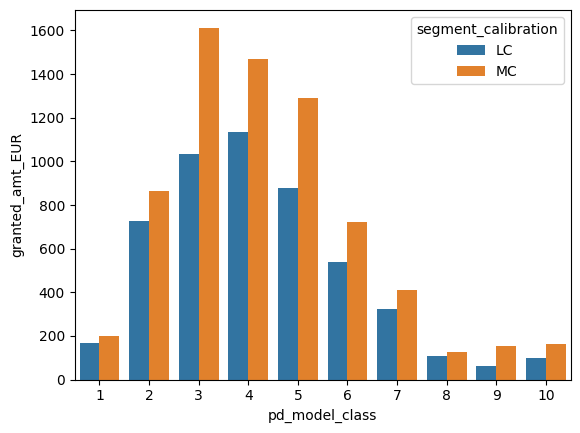

In [54]:
sns.barplot(data=counts, x="pd_model_class", y="granted_amt_EUR", hue="segment_calibration")

## Add tertile column

In [55]:
# Add tertiles column based on

# Step 1 : Group the observations from each rating grade by some relevant variable (granted amount)

#TODO: understand which one - maybe ask them for support
# rating grades : 'pd_model_class' OR 'pd_decided_class'
# relevant variable : (outstanding/granted amount) -> 	'issued_or_outstanding_amt_EUR'	OR 'granted_amt_EUR'

# significance level (alpha)
significance_level = 0.025

# Create tertiles for each group
df['tertile'] = df.groupby(['pd_model_class', 'segment_calibration'])['granted_amt_EUR']\
    .transform(lambda x: pd.qcut(x, q=3, labels=["Low", "Medium", "High"]))

df.head()

,cohort_obs_dt,segment_calibration,consolidated_id,default_first_in_12M_dt,pd_model_class,pd_model_pct,pd_decided_class,pd_decided_pct,issued_or_outstanding_amt_EUR,granted_amt_EUR,EaD_amt_EUR,RWA_amt_EUR,Validation_sample,class_variables_check,tertile
0,12/31/2021,MC,894649,NaN,3,0.002172,3,0.002172,10719602.04,11253399.26,2248320.40,830873.37,1,True,High
1,12/31/2022,MC,156028,NaN,6,0.024611,6,0.024611,10909561.43,11578473.65,2286312.29,1988221.54,1,True,High
2,12/31/2021,LC,89270,NaN,5,0.010027,5,0.010027,610341.92,1610341.92,361641.92,194084.49,1,True,Medium
3,12/31/2022,LC,995075,NaN,2,0.001260,2,0.001260,634525.00,1635000.00,238205.00,50170.38,1,True,Medium
4,12/31/2021,LC,629963,NaN,4,0.004863,4,0.004863,156861.64,300000.00,31372.33,30385.33,1,True,Low


## **Create demo data to verify below pipeline**

In [56]:
# tertiles_manual_check (check the excel - for a nice table overview)
# df.to_csv("/content/drive/MyDrive/Statistics/tertiles_manual_check.csv")

In [57]:
## Uncomment to test with demo data to verify aggregations
########################################################################

# df = pd.read_csv("/content/drive/MyDrive/Statistics/demo_data_to_test_dataprep.csv")
# df.head()

## Number of defaults (in bin) data

In [58]:
# Calculate the number of defaults (default rate)
agg_df = df.groupby(['pd_model_class', 'segment_calibration', 'tertile']).agg(
    D_in_bin=('default_first_in_12M_dt', lambda x: x.notna().sum()),
    Not_D_in_bin=('default_first_in_12M_dt', lambda x: x.isna().sum()),
    Observations_in_bin=('pd_model_class', lambda x: x.count())
)

agg_df["DR"] = agg_df["D_in_bin"] / agg_df["Observations_in_bin"]
agg_df = agg_df.reset_index()
agg_df.head(6) # display

,pd_model_class,segment_calibration,tertile,D_in_bin,Not_D_in_bin,Observations_in_bin,DR
0,1,LC,Low,0,56,56,0.000000
1,1,LC,Medium,0,55,55,0.000000
2,1,LC,High,0,55,55,0.000000
3,1,MC,Low,1,66,67,0.014925
4,1,MC,Medium,0,66,66,0.000000
5,1,MC,High,0,66,66,0.000000


## Add the Out of bin data

In [59]:
total = df.groupby(['pd_model_class', 'segment_calibration']).agg(
    defaulted=('default_first_in_12M_dt', lambda x: x.notna().sum()),
    not_defaulted=('default_first_in_12M_dt', lambda x: x.isna().sum()),
    Observations_in_bin=('pd_model_class', lambda x: x.count())
)
total.columns = ["Tot_defaulted", "Tot_not_defaulted", "Tot_observations"]
total = total.reset_index()
total.head(4)

,pd_model_class,segment_calibration,Tot_defaulted,Tot_not_defaulted,Tot_observations
0,1,LC,0,166,166
1,1,MC,1,198,199
2,2,LC,2,724,726
3,2,MC,0,863,863


In [60]:
agg_df_n = agg_df.merge(total, on=["pd_model_class", "segment_calibration"])
agg_df_n["D_out_of_bin"] = agg_df_n["Tot_defaulted"] - agg_df_n["D_in_bin"]
agg_df_n["Not_D_out_of_bin"] = agg_df_n["Tot_not_defaulted"] - agg_df_n["Not_D_in_bin"]
agg_df_n["Tot_out_of_bin"] = agg_df_n["Tot_observations"] - agg_df_n["Observations_in_bin"]
agg_df_n["DR_out_of_bin"] = agg_df_n["D_out_of_bin"] / agg_df_n["Tot_out_of_bin"]
agg_df_n.head(6)

,pd_model_class,segment_calibration,tertile,D_in_bin,Not_D_in_bin,Observations_in_bin,DR,Tot_defaulted,Tot_not_defaulted,Tot_observations,D_out_of_bin,Not_D_out_of_bin,Tot_out_of_bin,DR_out_of_bin
0,1,LC,Low,0,56,56,0.000000,0,166,166,0,110,110,0.000000
1,1,LC,Medium,0,55,55,0.000000,0,166,166,0,111,111,0.000000
2,1,LC,High,0,55,55,0.000000,0,166,166,0,111,111,0.000000
3,1,MC,Low,1,66,67,0.014925,1,198,199,0,132,132,0.000000
4,1,MC,Medium,0,66,66,0.000000,1,198,199,1,132,133,0.007519
5,1,MC,High,0,66,66,0.000000,1,198,199,1,132,133,0.007519


# Run homogenity test

## **Function to calculate the homogenity test**

In [61]:
import numpy as np
from scipy.stats import chisquare
from scipy.stats import chi2

def calculate_homogenity_test(observations):
    """
    This functions covers the homogenity test implementation described here :
        https://courses.lumenlearning.com/wm-concepts-statistics/chapter/test-of-homogeneity/
    The functions is inspired from :
        https://rowannicholls.github.io/python/statistics/hypothesis_testing/chi_squared.html#homogeneity-test

    Testing if the different samples come from the same population

    params: observations - it could be a matrix of any kind but tested
        with 2x2 matrix

    Returns:
        p_value that helps to accept/reject a hypothesis
    """
    row_totals = np.array([np.sum(observations, axis=1)])
    col_totals = np.array([np.sum(observations, axis=0)])

    n = np.sum(observations)

    # Calculate the expected observations
    expected = np.dot(row_totals.T, col_totals) / n

    # Calculate chi-square test statistic
    chisq, _ = chisquare(observations, expected)
    chisq = np.sum(chisq)

    # Degrees of freedom
    rows = observations.shape[0]
    cols = observations.shape[1]
    df = (rows - 1) * (cols - 1)

    # Convert chi-square test statistic to p-value
    p = 1 - chi2.cdf(chisq, df)

    # Uncomment to display the value
    # print(f'p = {p:5.3f}')
    return f'{p:5.3f}'
    # return p

## Demo homogenity test

In [62]:
# 1st row of each key in the dictionary shows the defaulted (in/out of bin)
# 2nd row of each key in the dictionary shows the non_defaulted (in/out of bin)
observations_dict ={"High": np.array(
    [
        [181, 506],
        [596, 1943]
    ]
),
        "Mid": np.array(
    [
        [207, 779],
        [480, 1760]
    ]
),
        "Low": np.array(
    [
        [299, 388],
        [1164, 1375]
    ]
)}

for observation_k, observation_v in observations_dict.items():
    print(observation_k, ":", calculate_homogenity_test(observation_v))
    print(25*"=")

High : 0.118
Mid : 0.781
Low : 0.278


## Run homogenity test on assesment data

In [63]:
import itertools
segment_calibration = list(agg_df_n["segment_calibration"].unique())
pd_model_class = list(agg_df_n["pd_model_class"].unique())
level = list(agg_df_n["tertile"].unique())

combinations = list(itertools.product(segment_calibration, pd_model_class, level))

# Uncomment To test
##############################

# for combination in combinations:
#     print(combination)

In [64]:
import numpy as np

observations = {}

tmp_df = agg_df_n.copy(deep=True)
for combination in combinations:
    l = (
        tmp_df[["D_in_bin", "D_out_of_bin"]][
        (tmp_df["segment_calibration"]==combination[0]) &
        (tmp_df["pd_model_class"]==combination[1]) &
        (tmp_df["tertile"]==combination[2])
                    ].values.tolist()
    )

    flattened_list = list(itertools.chain(*l))

    l2 = (
        tmp_df[["Not_D_in_bin", "Not_D_out_of_bin"]][
        (tmp_df["segment_calibration"]==combination[0]) &
        (tmp_df["pd_model_class"]==combination[1]) &
        (tmp_df["tertile"]==combination[2])
                    ].values.tolist()
    )

    flattened_list_2 = list(itertools.chain(*l2))

    # print(combination)
    # print(flattened_list)
    # print(flattened_list_2)

    observation = np.array(
      [
          flattened_list,
          flattened_list_2
      ]
      )

    observations[combination] = observation

# Append the p_value to empty data frame
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
result_df = pd.DataFrame(columns=['segment_calibration', 'pd_model_class',
                                  'tertile', 'p_value'])

for observation_k, observation_v in observations.items():
    if observation_v.size:
        print(observation_k, ":", calculate_homogenity_test(observation_v))
        print(25*"=")
        result_df = result_df.append(
            {"segment_calibration" : observation_k[0],
             "pd_model_class" : observation_k[1],
             "tertile" : observation_k[2],
             "p_value" : calculate_homogenity_test(observation_v)
                            }, ignore_index=True)

('LC', 1, 'Low') :   nan
('LC', 1, 'Medium') :   nan
('LC', 1, 'High') :   nan
('LC', 2, 'Low') : 0.317
('LC', 2, 'Medium') : 0.617


/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:7407: RuntimeWarning: invalid value encountered in true_divide
  terms = (f_obs_float - f_exp)**2 / f_exp
/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:7407: RuntimeWarning: invalid value encountered in true_divide
  terms = (f_obs_float - f_exp)**2 / f_exp
/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:7407: RuntimeWarning: invalid value encountered in true_divide
  terms = (f_obs_float - f_exp)**2 / f_exp
/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:7407: RuntimeWarning: invalid value encountered in true_divide
  terms = (f_obs_float - f_exp)**2 / f_exp
/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:7407: RuntimeWarning: invalid value encountered in true_divide
  terms = (f_obs_float - f_exp)**2 / f_exp
/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:7407: RuntimeWarning: invalid value encountered in true_divide
  terms = (f_obs_

('LC', 2, 'High') : 0.617
('LC', 3, 'Low') : 0.997
('LC', 3, 'Medium') : 0.386
('LC', 3, 'High') : 0.384
('LC', 4, 'Low') : 0.313
('LC', 4, 'Medium') : 0.320
('LC', 4, 'High') : 0.045
('LC', 5, 'Low') : 0.721
('LC', 5, 'Medium') : 0.724
('LC', 5, 'High') : 0.477
('LC', 6, 'Low') : 0.717
('LC', 6, 'Medium') : 0.728
('LC', 6, 'High') : 0.478
('LC', 7, 'Low') : 0.716
('LC', 7, 'Medium') : 0.474
('LC', 7, 'High') : 0.725
('LC', 8, 'Low') : 0.954
('LC', 8, 'Medium') : 0.962
('LC', 8, 'High') : 0.991
('LC', 9, 'Low') : 0.047
('LC', 9, 'Medium') : 0.776
('LC', 9, 'High') : 0.023
('LC', 10, 'Low') : 0.471
('LC', 10, 'Medium') : 0.152
('LC', 10, 'High') : 0.481
('MC', 1, 'Low') : 0.159
('MC', 1, 'Medium') : 0.480
('MC', 1, 'High') : 0.480
('MC', 2, 'Low') :   nan
('MC', 2, 'Medium') :   nan
('MC', 2, 'High') :   nan
('MC', 3, 'Low') : 0.220
('MC', 3, 'Medium') : 0.999
('MC', 3, 'High') : 0.221
('MC', 4, 'Low') : 0.617
('MC', 4, 'Medium') : 0.617
('MC', 4, 'High') : 0.317
('MC', 5, 'Low') : 0.27

/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:7407: RuntimeWarning: invalid value encountered in true_divide
  terms = (f_obs_float - f_exp)**2 / f_exp
/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:7407: RuntimeWarning: invalid value encountered in true_divide
  terms = (f_obs_float - f_exp)**2 / f_exp
/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:7407: RuntimeWarning: invalid value encountered in true_divide
  terms = (f_obs_float - f_exp)**2 / f_exp


In [65]:
# result_df

## Combine data frames and return final df

In [66]:
# combine result_df and the previous table to return the needed result

In [67]:
pre_final_df = agg_df_n.merge(result_df,  on=["pd_model_class", "segment_calibration", "tertile"])

In [68]:
pre_final_df = pre_final_df.rename(columns={'Observations_in_bin': 'N_in_bin',
                                            'DR': 'DR_in_bin',
                                            'Tot_out_of_bin' : 'N_out_of_bin'
                                            })
# pre_final_df

In [69]:
final_LC = pre_final_df[['segment_calibration', 'pd_model_class', 'tertile',
                                       'N_in_bin', 'D_in_bin', 'DR_in_bin',
                                       'N_out_of_bin', 'D_out_of_bin', 'DR_out_of_bin',
                                       'p_value', 'segment_calibration'
                                       ]][pre_final_df["segment_calibration"]=="LC"]

final_MC = pre_final_df[['segment_calibration', 'pd_model_class', 'tertile',
                                       'N_in_bin', 'D_in_bin', 'DR_in_bin',
                                       'N_out_of_bin', 'D_out_of_bin', 'DR_out_of_bin',
                                       'p_value'
                                       ]][pre_final_df["segment_calibration"]=="MC"]

final_LC.to_csv("/content/drive/MyDrive/Statistics/output_LC.csv")
final_MC.to_csv("/content/drive/MyDrive/Statistics/output_MC.csv")

## Display special cases
- p_value not calculated due to division by zero in : (f_obs_float - f_exp)**2 / f_exp
- Expected behaviour

In [71]:
final_LC[
        (tmp_df["segment_calibration"]=="LC") &
        (tmp_df["pd_model_class"]==1)
]

<ipython-input-71-c96986d4997c>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  final_LC[


,segment_calibration,pd_model_class,tertile,N_in_bin,D_in_bin,DR_in_bin,N_out_of_bin,D_out_of_bin,DR_out_of_bin,p_value,segment_calibration
0,LC,1,Low,56,0,0.0,110,0,0.0,nan,LC
1,LC,1,Medium,55,0,0.0,111,0,0.0,nan,LC
2,LC,1,High,55,0,0.0,111,0,0.0,nan,LC


In [72]:
final_MC[
        (tmp_df["segment_calibration"]=="MC") &
        (tmp_df["pd_model_class"]==2)
]

<ipython-input-72-a6fb0a9a4934>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  final_MC[


,segment_calibration,pd_model_class,tertile,N_in_bin,D_in_bin,DR_in_bin,N_out_of_bin,D_out_of_bin,DR_out_of_bin,p_value
9,MC,2,Low,288,0,0.0,575,0,0.0,nan
10,MC,2,Medium,287,0,0.0,576,0,0.0,nan
11,MC,2,High,288,0,0.0,575,0,0.0,nan


In [73]:
final_MC[
        (tmp_df["segment_calibration"]=="MC") &
        (tmp_df["pd_model_class"]==10)
]

<ipython-input-73-6af0ca589aea>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  final_MC[


,segment_calibration,pd_model_class,tertile,N_in_bin,D_in_bin,DR_in_bin,N_out_of_bin,D_out_of_bin,DR_out_of_bin,p_value
57,MC,10,Low,54,0,0.0,107,0,0.0,nan
58,MC,10,Medium,53,0,0.0,108,0,0.0,nan
59,MC,10,High,54,0,0.0,107,0,0.0,nan
